# Modeling  - Classification

The following notebook subject the data to classification algorithms to seperate the two classes.

## Contents

- [Logistic Regression](#logreg1)
- [Logistic Regression + class weights](#logreg2)
- [Logsitic Regression - Lasso](#lasso)
- [Logsitic Regression - Ridge](#ridge)
- [Support Vector Machines](#svm)
- [Gradient Boosting Classifiers - XGBoost](#gbc)
- [XGBoost + class weights](#gbc2)
- [Random Forests](#rf)
- [Summary](#summary)

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [1]:
import calendar
import seaborn as sns
sns.set(style='whitegrid')

import statsmodels.api as smapi

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot

from Utils.PipelineUtils import *
from Utils.DataUtils import *
from Utils.VizUtils import *

In [3]:
train_data = pd.read_csv("./train_data_scaled_encoded.csv")
val_data = pd.read_csv("./val_data_preprocessed.csv")
display(
    train_data.shape,
    train_data.head(),
    val_data.shape,
    val_data.head())

(8543, 38)

Administrative  Informational  ProductRelated  BounceRates  PageValues  SpecialDay  Revenue  \
0       -0.700298      -0.405807       -0.228228    -0.447944   -0.315005   -0.312378    False   
1        1.995396      -0.405807       -0.342283     0.093365   -0.315005   -0.312378    False   
2        5.290134       2.018536       11.063226    -0.350027    0.130124   -0.312378     True   
3       -0.700298      -0.405807       -0.616015     2.678117   -0.315005   -0.312378    False   
4       -0.400776      -0.405807       -0.410716    -0.447944    5.847602   -0.312378     True   

   BounceRates_x_PageValues  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_June  \
0                 -0.168900          0          0          0          0          0           0   
1                 -0.168900          0          0          0          0          1           0   
2                  0.100857          0          0          0          0          0           0   
3                 -0.168900          0          0          0          0          0           0   
4                 -0.168900          0          0          0          0          0           0   

   Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec  VisitorType_0  VisitorType_1  \
0          0          0          0          0          1          0            0.0            0.0   
1          0          0          0          0          0          0            0.0            1.0   
2          0          0          0          0          1          0            0.0            1.0   
3          0          0          0          0          1          0            0.0            1.0   
4          0          0          0          0          0          1            1.0            0.0   

   Weekend_0  quarter_0  quarter_1  quarter_2  OperatingSystems_agg_0  OperatingSystems_agg_1  \
0        0.0        0.0        0.0        1.0                     1.0                     0.0   
1        0.0        1.0        0.0        0.0                     0.0                     1.0   
2        0.0        0.0        0.0        1.0                     0.0                     0.0   
3        0.0        0.0        0.0        1.0                     0.0                     1.0   
4        0.0        0.0        0.0        1.0                     0.0                     0.0   

   OperatingSystems_agg_2  TrafficType_agg_0  TrafficType_agg_1  TrafficType_agg_2  \
0                     0.0                0.0                0.0                0.0   
1                     0.0                0.0                0.0                0.0   
2                     0.0                0.0                0.0                1.0   
3                     0.0                0.0                0.0                0.0   
4                     1.0                0.0                0.0                0.0   

   TrafficType_agg_3  TrafficType_agg_4  TrafficType_agg_5  TrafficType_agg_6  TrafficType_agg_7  \
0                0.0                0.0                0.0                0.0                1.0   
1                0.0                1.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0                0.0   

   TrafficType_agg_8  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                1.0

(1831, 38)

Administrative  Informational  ProductRelated  BounceRates  PageValues  SpecialDay  Revenue  \
0       -0.400776      -0.405807       -0.593204    -0.447944   -0.315005   -0.312378    False   
1        0.797310       1.210422        5.907936    -0.420562    0.162429   -0.312378    False   
2       -0.101255      -0.405807        0.478914    -0.366748    0.116945   -0.312378     True   
3        0.198267      -0.405807       -0.616015    -0.447944    2.112598   -0.312378     True   
4       -0.101255      -0.405807        1.687898    -0.433901   -0.315005   -0.312378    False   

   BounceRates_x_PageValues  Month_Jan  Month_Feb  Month_Mar  Month_Apr  Month_May  Month_June  \
0                 -0.168900          0          0          1          0          0           0   
1                 -0.087989          0          0          0          0          1           0   
2                  0.048168          0          0          0          0          0           1   
3                 -0.168900          0          0          0          0          0           0   
4                 -0.168900          0          0          0          0          1           0   

   Month_Jul  Month_Aug  Month_Sep  Month_Oct  Month_Nov  Month_Dec  VisitorType_0  VisitorType_1  \
0          0          0          0          0          0          0            0.0            1.0   
1          0          0          0          0          0          0            0.0            1.0   
2          0          0          0          0          0          0            0.0            1.0   
3          0          0          1          0          0          0            0.0            1.0   
4          0          0          0          0          0          0            0.0            1.0   

   Weekend_0  quarter_0  quarter_1  quarter_2  OperatingSystems_agg_0  OperatingSystems_agg_1  \
0        0.0        0.0        0.0        0.0                     0.0                     0.0   
1        0.0        1.0        0.0        0.0                     1.0                     0.0   
2        0.0        1.0        0.0        0.0                     1.0                     0.0   
3        0.0        0.0        1.0        0.0                     1.0                     0.0   
4        0.0        1.0        0.0        0.0                     0.0                     0.0   

   OperatingSystems_agg_2  TrafficType_agg_0  TrafficType_agg_1  TrafficType_agg_2  \
0                     0.0                1.0                0.0                0.0   
1                     0.0                0.0                0.0                0.0   
2                     0.0                0.0                0.0                0.0   
3                     0.0                0.0                0.0                0.0   
4                     1.0                0.0                0.0                0.0   

   TrafficType_agg_3  TrafficType_agg_4  TrafficType_agg_5  TrafficType_agg_6  TrafficType_agg_7  \
0                0.0                0.0                0.0                0.0                0.0   
1                0.0                1.0                0.0                0.0                0.0   
2                1.0                0.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                1.0                0.0   

   TrafficType_agg_8  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

In [4]:
rev_palette = {True:'cornflowerblue', False:'mistyrose'}

# Quick mapping
train_data["Revenue"] = train_data["Revenue"].astype(int)
val_data["Revenue"] = val_data["Revenue"].astype(int)

In [5]:
# Define some helper functions
def get_classification_reports(model, x_val, y_val, debug=True):
    y_pred_test = model.predict(x_val) > 0.5
    # f1_score(y_true=y_train.values.ravel(), y_pred=y_pred_train, labels=["True","Pred"])

    if debug:
        print("Classification Reports ---\n\n")
    val_class_rep = classification_report(y_true=y_val, y_pred=y_pred_test)
    if debug:
        print("Validation data:\n", val_class_rep)
    f1score = f1_score(y_true=y_val.values.ravel(), y_pred=y_pred_test)
    if debug:
        print("F1 score:", np.round(f1score, 2))
    return f1score
    
    
def get_confusion_mat(y_true, y_pred, colnames=["Pred_0", "Pred_1"], index=["True_0", "True_1"]):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=colnames, index=index)
    
    
def evaluate_model(model, alpha_val = 0.05, figsize=(12,20), show_coef_graph=False):
    pvals = model.pvalues.to_frame()
    pvals.sort_values(0, inplace=True, ascending=True)
    significant_features = pvals[pvals[0]<=alpha_val].index
    significant_features = [c for c in significant_features if "const" not in c]

    coeffs = model.params.to_frame()
    coeffs = coeffs.reset_index(drop=False)
    # coeffs = coeffs[coeffs["index"].isin(significant_features)]
    coeffs.columns = ["column", "coef"]

    f, ax = plt.subplots(2, 1, figsize=figsize)
    g = sns.barplot(y=pvals.index, x=pvals[0], ax=ax[0])
    g.set(title="P values of features", xlabel="p-value")
    g.axvline(x=alpha_val, linestyle="--")
    g = sns.barplot(y="column", x="coef", 
                    data=coeffs[coeffs["column"].isin(significant_features)], 
                    ax=ax[1])
    g.set(title="Coefficient of significant columns")
    if not show_coef_graph:
        ax[1].set(visible=False)
    plt.show()
        
    return significant_features


def pr_curve(model, x_val, y_val):
    # predict probabilities
    lr_probs = model.predict(x_val)
    # predict class values
    yhat = lr_probs > 0.5
    # calculate precision and recall for each threshold
    lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
    # calculate scores
    lr_f1, lr_auc = f1_score(y_val, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    # plot the precision-recall curves
    no_skill = len(y_val[y_val==1]) / len(y_val)
#     pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.')
    # axis labels
    pyplot.title("AUC: " + str(np.round(lr_auc, 2)))
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

--------------

# Logistic Regression<a id='logreg1'></a>

Use GLM statsmodels logistic regression on the dataset.

NTOE: The standard _logit_ module gives approximation errors and produces NaNs

Since there is a substantial class imbalance, we should use precision recall curves instead of ROC curves

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [6]:
# First make a copy of the dataset and add a constant
train_data_sm = train_data.copy()
train_data_sm = smapi.add_constant(train_data_sm)
val_data_sm = smapi.add_constant(val_data)
ycol = ["Revenue"]
xcol = [c for c in train_data_sm.columns if c not in ycol]

In [7]:
# from sklearn.manifold import TSNE
# model=TSNE(learning_rate=100)
# Tsne_transformed_train = model.fit_transform(train_data_sm)
# Tsne_transformed_val = model.fit_transform(val_data_sm)
# xs_train = Tsne_transformed_train[:,0]
# ys_train = Tsne_transformed_train[:,1]
# xs_val = Tsne_transformed_val[:,0]
# ys_val = Tsne_transformed_val[:,1]
# save_to_disk(xs_train, "tsne_x_train.pkl")
# save_to_disk(ys_train, "tsne_y_train.pkl")
# save_to_disk(xs_val, "tsne_x_val.pkl")
# save_to_disk(ys_val, "tsne_y_val.pkl")

In [8]:
xs_train = load_from_disk("./tsne_x_train.pkl")
ys_train = load_from_disk("./tsne_y_train.pkl")
xs_val = load_from_disk("./tsne_x_val.pkl")
ys_val = load_from_disk("./tsne_y_val.pkl")
xs_train = list(xs_train)
ys_train = list(ys_train)
xs_val = list(xs_val)
ys_val = list(ys_val)

### Statsmodels Logistic Regression

In [9]:
# Use Statsmodels
mod = smapi.GLM(endog=train_data_sm[ycol], 
                exog=train_data_sm[xcol],
                family=smapi.families.Binomial(smapi.families.links.logit))

# fit the model
result = mod.fit()

print (result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Revenue   No. Observations:                 8543
Model:                            GLM   Df Residuals:                     8511
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2514.6
Date:                Thu, 05 Mar 2020   Deviance:                       5029.3
Time:                        07:37:08   Pearson chi2:                 1.99e+08
No. Iterations:                   100   Covariance Type:             nonrobust
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.0637      0.239     -8.626      0.000      -2.533      -1.595
Administra

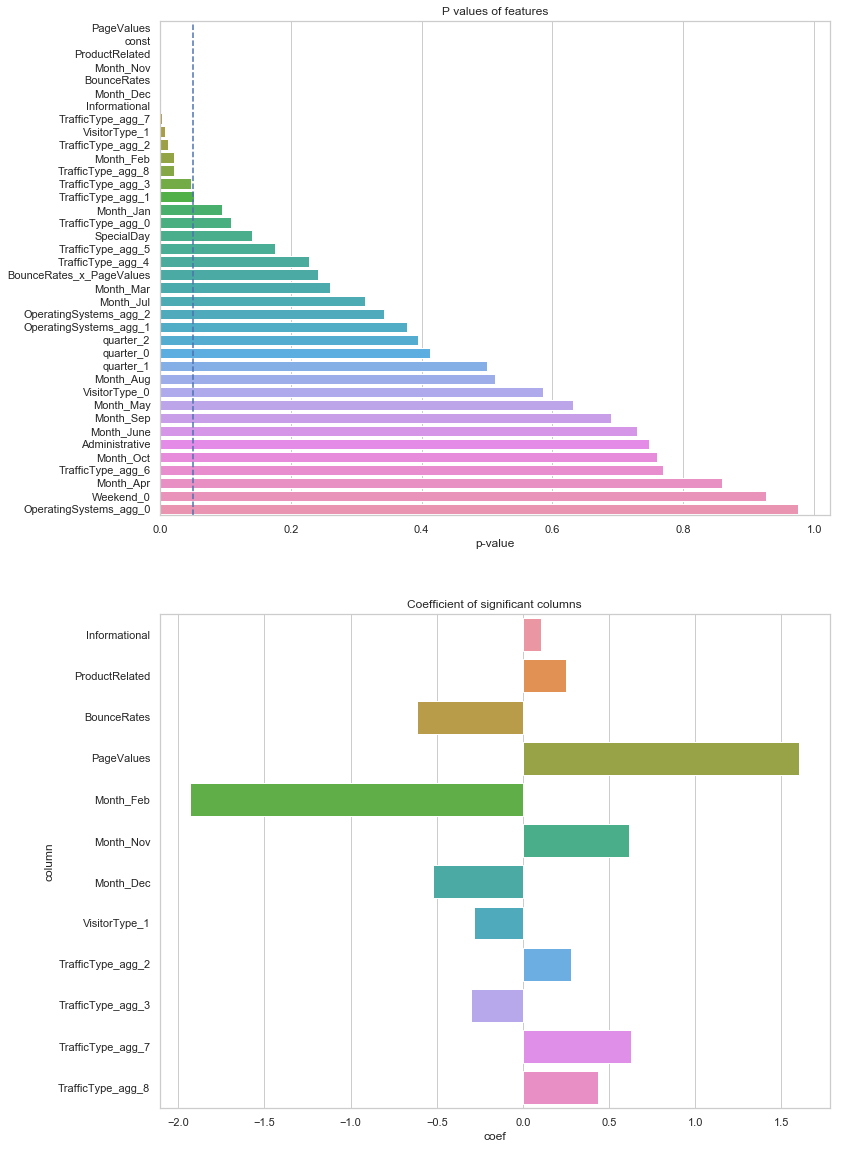

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.90      0.98      0.93      1545
           1       0.75      0.39      0.51       286

    accuracy                           0.88      1831
   macro avg       0.82      0.68      0.72      1831
weighted avg       0.87      0.88      0.87      1831

F1 score: 0.51


0.5137614678899083

In [10]:
significant_features = evaluate_model(model=result, show_coef_graph=True)
get_classification_reports(result, val_data_sm[xcol], val_data_sm[ycol])
# pr_curve(model=result, x_val=val_data_sm[xcol], y_val=val_data_sm[ycol].values.ravel())

In [11]:
train_ylabels = result.predict(train_data_sm[xcol]) > 0.5
val_ylabels = result.predict(val_data_sm[xcol]) > 0.5

In [12]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_true=train_data[ycol], y_pred=train_ylabels), columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"]))

print("Validation confusion matrix:") 
display(pd.DataFrame(confusion_matrix(y_true=val_data[ycol], y_pred=val_ylabels), columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"]))

Train confusion matrix:


Pred_0  Pred_1
True_0    7036     171
True_1     814     522

Validation confusion matrix:


Pred_0  Pred_1
True_0    1507      38
True_1     174     112

While precision is fairly high, the recall values are quite low. 

### Training the model only on significant features

In [13]:
for s in np.sort(significant_features):
    print("\t", s)

	 BounceRates
	 Informational
	 Month_Dec
	 Month_Feb
	 Month_Nov
	 PageValues
	 ProductRelated
	 TrafficType_agg_2
	 TrafficType_agg_3
	 TrafficType_agg_7
	 TrafficType_agg_8
	 VisitorType_1


In [14]:
save_to_disk(significant_features, "sig_features.pkl")

In [15]:
# Add a constant
ycol = ["Revenue"]
xcol2 = significant_features + ["const"]

# Use Statsmodels
mod = smapi.GLM(endog=train_data_sm[ycol], 
                exog=train_data_sm[xcol2],
                family=smapi.families.Binomial(smapi.families.links.logit))

# fit the model
result = mod.fit()

print (result.summary())

# significant_features = evaluate_model(model=result)
get_classification_reports(result, val_data_sm[xcol2], val_data_sm[ycol])
# pr_curve(model=result, x_val=val_data_sm[xcol], y_val=val_data_sm[ycol].values.ravel())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Revenue   No. Observations:                 8543
Model:                            GLM   Df Residuals:                     8530
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2532.0
Date:                Thu, 05 Mar 2020   Deviance:                       5063.9
Time:                        07:37:10   Pearson chi2:                 1.40e+08
No. Iterations:                     8   Covariance Type:             nonrobust
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
PageValues            1.5783      0.054     29.261      0.000       1.473       1.684
ProductRelated        0.2502   

0.5127020785219399

In [16]:
train_ylabels = result.predict(train_data_sm[xcol2]) > 0.5
val_ylabels = result.predict(val_data_sm[xcol2]) > 0.5

In [17]:
print("Train confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_true=train_data[ycol], y_pred=train_ylabels), columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"]))

print("Validation confusion matrix:") 
display(pd.DataFrame(confusion_matrix(y_true=val_data[ycol], y_pred=val_ylabels), columns=["Pred_0", "Pred_1"], index=["True_0", "True_1"]))

Train confusion matrix:


Pred_0  Pred_1
True_0    7046     161
True_1     810     526

Validation confusion matrix:


Pred_0  Pred_1
True_0    1509      36
True_1     175     111

The F1 score has improved to 0.50 but recall values have only improved slightly

Elasticnet Regularization did not improve the results from simple feature selection.

## SkLearn Logistic Regression 

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.90      0.98      0.93      1545
           1       0.75      0.39      0.51       286

    accuracy                           0.88      1831
   macro avg       0.82      0.68      0.72      1831
weighted avg       0.87      0.88      0.87      1831

F1 score: 0.51
Train confusion matrix:


Pred_0  Pred_1
True_0    7036     171
True_1     814     522

Validation confusion matrix:


Pred_0  Pred_1
True_0    1507      38
True_1     174     112

No handles with labels found to put in legend.


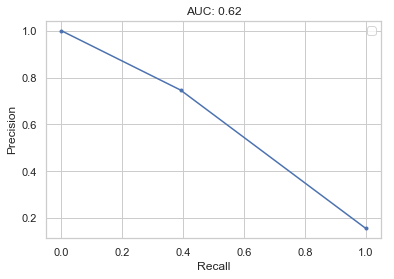

In [65]:
logit = LogisticRegression(penalty='none', class_weight={0:1, 1:1}, solver='lbfgs')
logit = logit.fit(X=train_data_sm[xcol], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(xcol, np.round(logit.coef_[0],2))))
coef_df.columns = ["column", "coef"]
intercept = logit.intercept_

train_ylabels = logit.predict(train_data_sm[xcol])
val_ylabels = logit.predict(val_data_sm[xcol])

get_classification_reports(logit, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(logit, val_data_sm[xcol], val_data_sm[ycol])

scores: [0.73 0.71 0.72 0.71 0.74]


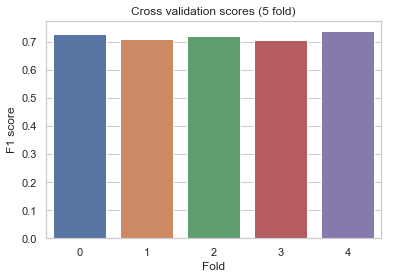

In [66]:
# Perform 5-fold cross validation
scores = cross_val_score(logit, train_data_sm[xcol], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("scores:", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

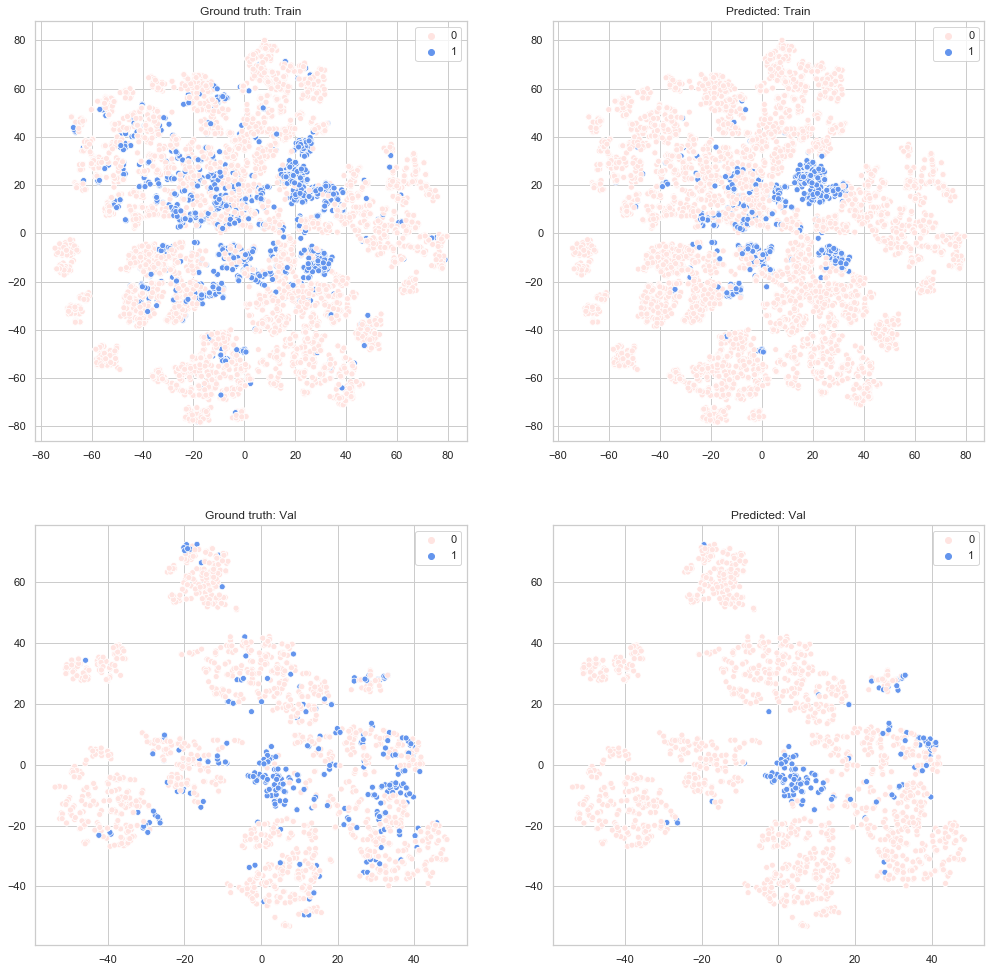

In [19]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

# SkLearn Logistic Regression with class weights<a id='logreg2'></a>

Best parameters : {'class_weight': {0: 0.20666666666666667, 1: 0.7933333333333333}}


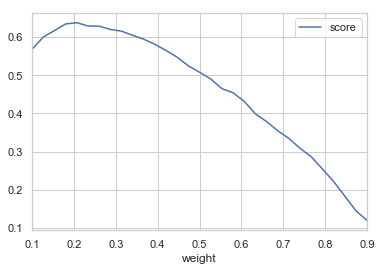

In [20]:
weights = np.linspace(0.1, 0.9, 31)

gsc = GridSearchCV(
    estimator=LogisticRegression(penalty='none', solver='lbfgs', max_iter=1e3),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(train_data_sm[xcol], train_data_sm[ycol].values.ravel())

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1545
           1       0.58      0.68      0.62       286

    accuracy                           0.87      1831
   macro avg       0.76      0.79      0.77      1831
weighted avg       0.88      0.87      0.88      1831

F1 score: 0.62
Train confusion matrix:


Pred_0  Pred_1
True_0    6612     595
True_1     420     916

Validation confusion matrix:


Pred_0  Pred_1
True_0    1404     141
True_1      92     194

No handles with labels found to put in legend.


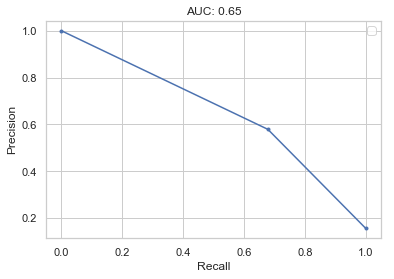

In [21]:
# logit = LogisticRegression(penalty='none', solver='lbfgs', **grid_result.best_params_)
logit = LogisticRegression(penalty='none', solver='lbfgs', class_weight={0: 0.20666666666666667, 1: 0.7933333333333333})
logit = logit.fit(X=train_data_sm[xcol], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(xcol, np.round(logit.coef_[0],2))))
coef_df.columns = ["column", "coef"]
intercept = logit.intercept_

train_ylabels = logit.predict(train_data_sm[xcol])
val_ylabels = logit.predict(val_data_sm[xcol])

get_classification_reports(logit, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(logit, val_data_sm[xcol], val_data_sm[ycol])

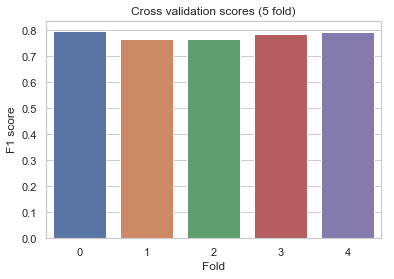

In [29]:
# Perform 5-fold cross validation
scores = cross_val_score(logit, train_data_sm[xcol], train_data_sm[ycol], cv=5, scoring='f1_macro')
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

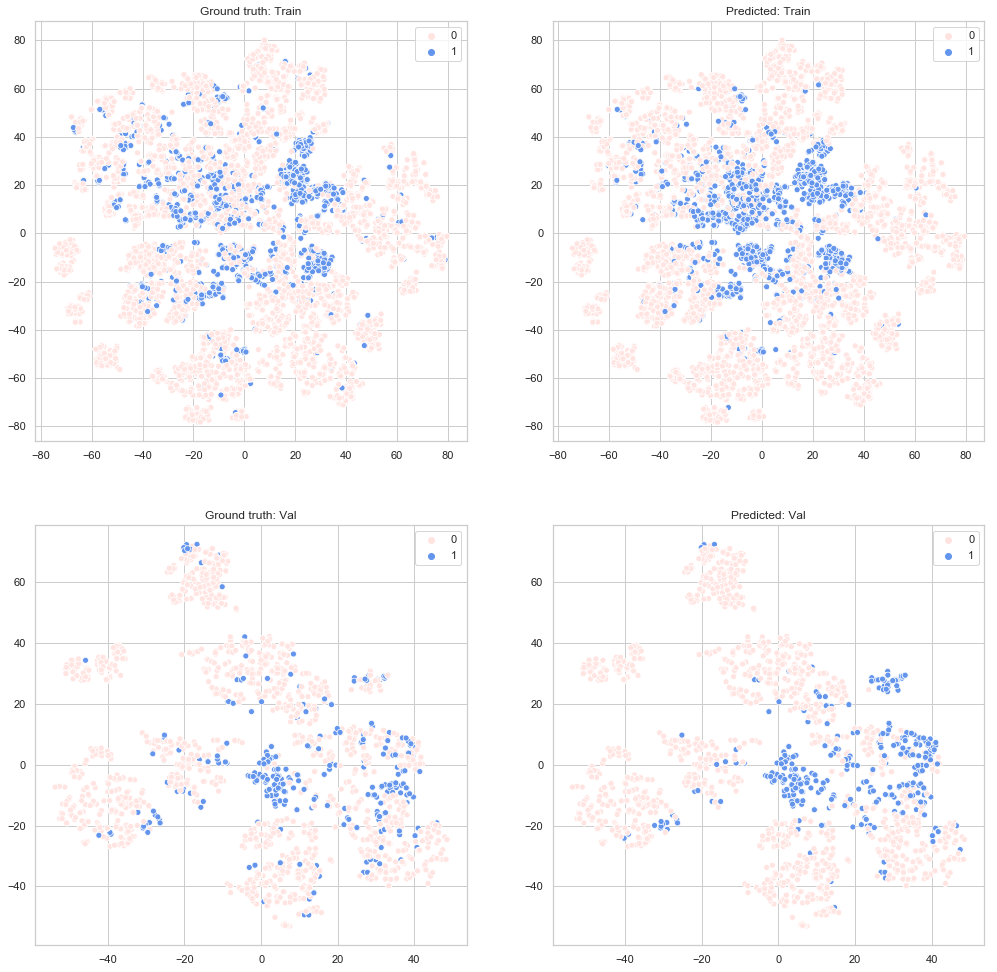

In [22]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

## SkLearn Logistic Regression with class weights on significant features

Best parameters : {'class_weight': {0: 0.20666666666666667, 1: 0.7933333333333333}}


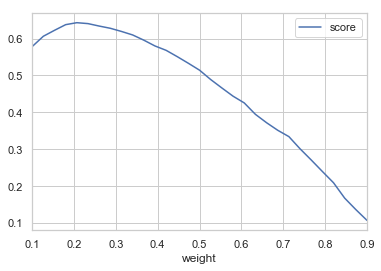

In [23]:
weights = np.linspace(0.1, 0.9, 31)

gsc = GridSearchCV(
    estimator=LogisticRegression(penalty='none', solver='lbfgs', max_iter=1e3),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(train_data_sm[significant_features], train_data_sm[ycol].values.ravel())

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1545
           1       0.59      0.67      0.63       286

    accuracy                           0.87      1831
   macro avg       0.76      0.79      0.78      1831
weighted avg       0.88      0.87      0.88      1831

F1 score: 0.63
Train confusion matrix:


Pred_0  Pred_1
True_0    6606     601
True_1     414     922

Validation confusion matrix:


Pred_0  Pred_1
True_0    1411     134
True_1      95     191

No handles with labels found to put in legend.


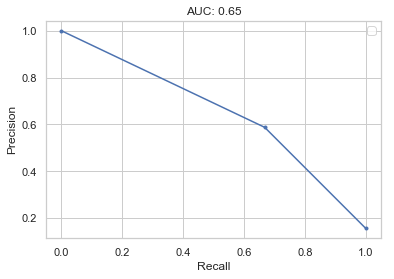

In [32]:
# logit = LogisticRegression(penalty='none', solver='lbfgs', **grid_result.best_params_)
logit = LogisticRegression(penalty='none', solver='lbfgs', class_weight={0: 0.20666666666666667, 1: 0.7933333333333333})
logit = logit.fit(X=train_data_sm[significant_features], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(significant_features, np.round(logit.coef_[0],2))))
coef_df.columns = ["column", "coef"]
intercept = logit.intercept_

train_ylabels = logit.predict(train_data_sm[significant_features])
val_ylabels = logit.predict(val_data_sm[significant_features])

get_classification_reports(logit, val_data_sm[significant_features], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(logit, val_data_sm[significant_features], val_data_sm[ycol])

scores [0.8  0.78 0.77 0.79 0.79]


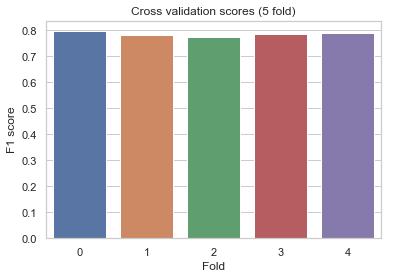

In [64]:
# Perform 5-fold cross validation
scores = cross_val_score(logit, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("scores", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

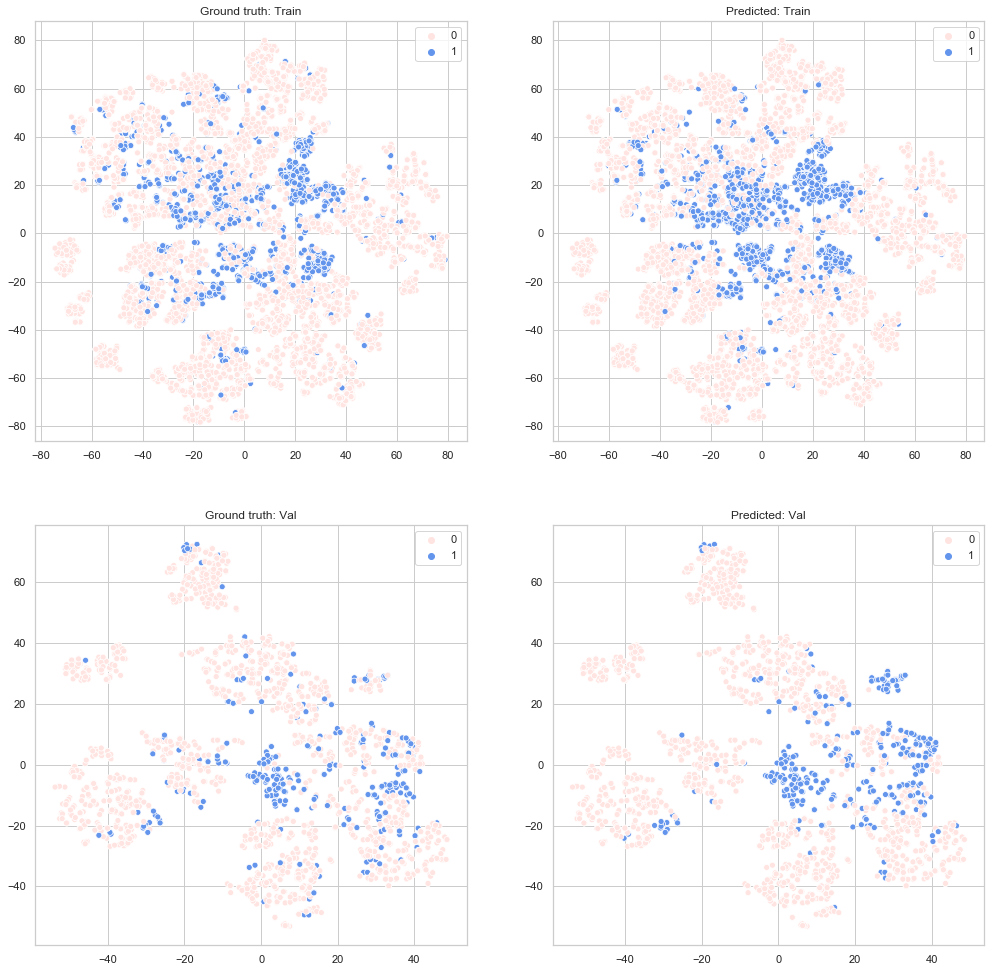

In [25]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

In [26]:
save_to_disk(logit, "./logit.pkl")

# Regularized Logistic Regression - Lasso<a id='lasso'></a>

column  coef
1      Administrative  0.03
2       Informational  0.12
3      ProductRelated  0.28
5          PageValues  2.22
14          Month_Jul  0.15
16          Month_Sep  0.06
18          Month_Nov  0.74
24          quarter_1  0.03
29  TrafficType_agg_0  0.12
31  TrafficType_agg_2  0.22
33  TrafficType_agg_4  0.16
34  TrafficType_agg_5  0.41
36  TrafficType_agg_7  0.47
37  TrafficType_agg_8  0.39

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      1545
           1       0.59      0.67      0.63       286

    accuracy                           0.88      1831
   macro avg       0.77      0.79      0.78      1831
weighted avg       0.88      0.88      0.88      1831

F1 score: 0.63
Train confusion matrix:


Pred_0  Pred_1
True_0    6615     592
True_1     419     917

Validation confusion matrix:


Pred_0  Pred_1
True_0    1412     133
True_1      93     193

No handles with labels found to put in legend.


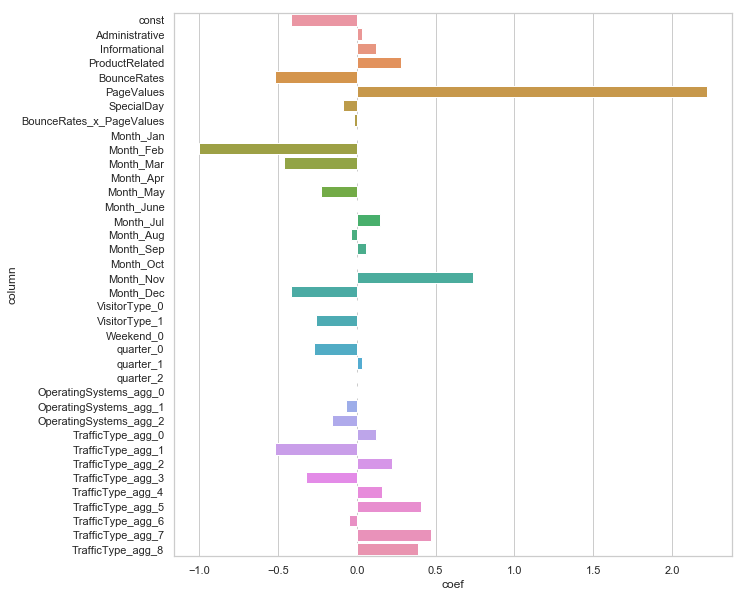

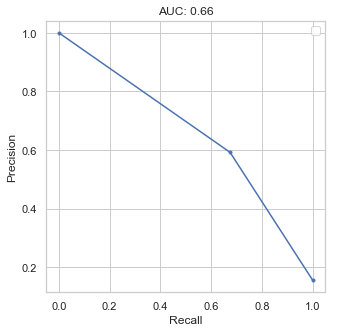

In [37]:
ycol = ["Revenue"]
xcol = [c for c in train_data_sm.columns if c not in ycol]

# lasso = LogisticRegression(penalty='l1', tol=1e-5, **grid_result.best_params_)
lasso = LogisticRegression(penalty='l1', tol=1e-5, class_weight={0: 0.20666666666666667, 1: 0.7933333333333333})
lasso = lasso.fit(X=train_data_sm[xcol], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(xcol, np.round(lasso.coef_[0],2))))
coef_df.columns = ["column", "coef"]
display(coef_df.query("coef>0"))
intercept = lasso.intercept_

f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(x="coef", y="column", data=coef_df, ax=ax)

train_ylabels = lasso.predict(train_data_sm[xcol])
val_ylabels = lasso.predict(val_data_sm[xcol])

get_classification_reports(lasso, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

f, ax = plt.subplots(1,1,figsize=(5,5))
pr_curve(lasso, val_data_sm[xcol], val_data_sm[ycol])

Scores : [0.8  0.78 0.78 0.79 0.79]


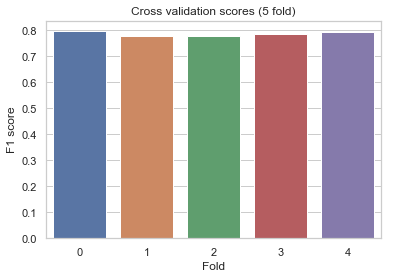

In [63]:
# Perform 5-fold cross validation
scores = cross_val_score(lasso, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Scores :", np.round(scores,2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

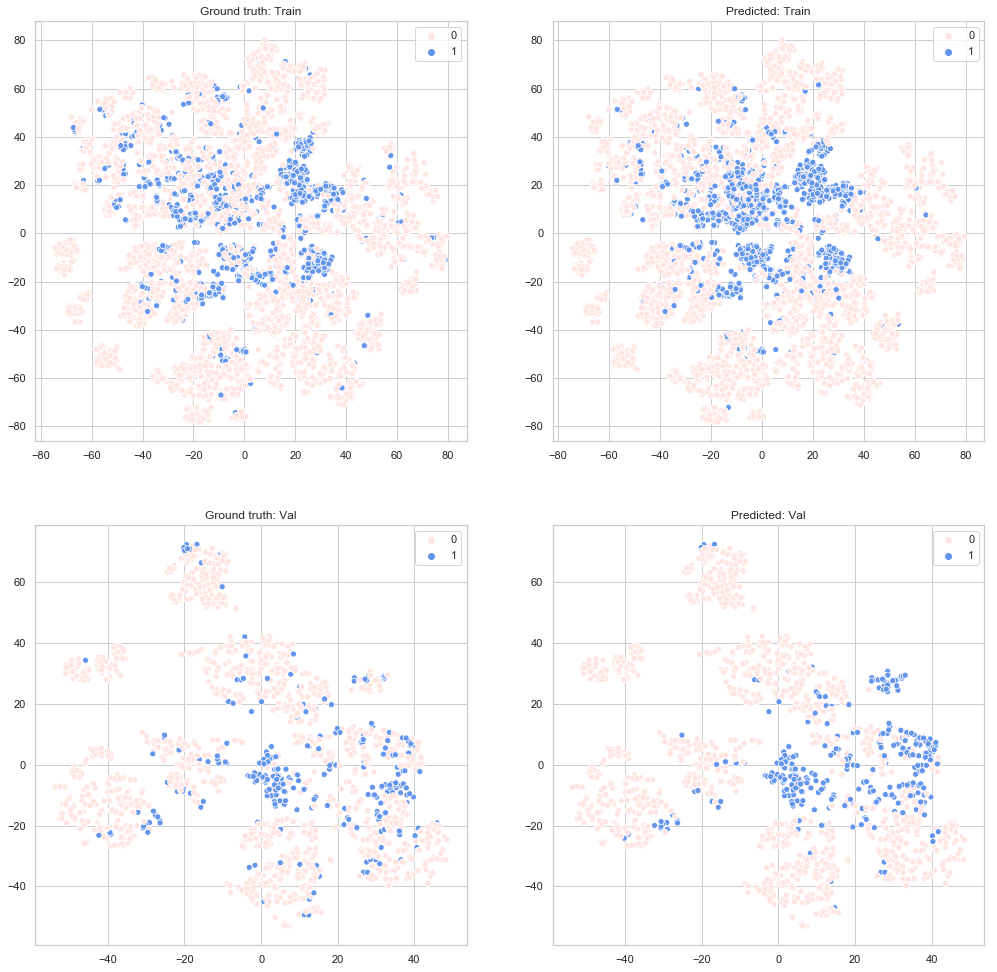

In [28]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

In [29]:
save_to_disk(lasso, "./lasso.pkl")

# Regularized Logistic Regression - Ridge<a id='ridge'></a>

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1545
           1       0.58      0.68      0.63       286

    accuracy                           0.87      1831
   macro avg       0.76      0.79      0.78      1831
weighted avg       0.88      0.87      0.88      1831

F1 score: 0.63
Train confusion matrix:


Pred_0  Pred_1
True_0    6613     594
True_1     421     915

Validation confusion matrix:


Pred_0  Pred_1
True_0    1406     139
True_1      92     194

No handles with labels found to put in legend.


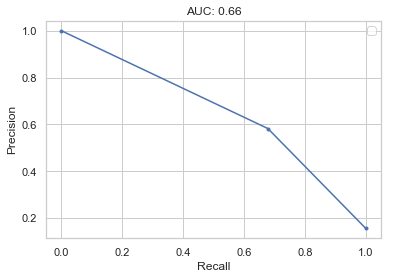

In [39]:
# ridge = LogisticRegression(penalty='l2', tol=1e-4, **grid_result.best_params_)
ridge = LogisticRegression(penalty='l2', tol=1e-4, class_weight={0: 0.20666666666666667, 1: 0.7933333333333333})
ridge = ridge.fit(X=train_data_sm[xcol], y=train_data_sm[ycol])

coef_df = pd.DataFrame(list(zip(xcol, np.round(ridge.coef_,2))))
coef_df.columns = ["column", "coef"]
intercept = ridge.intercept_

train_ylabels = ridge.predict(train_data_sm[xcol])
val_ylabels = ridge.predict(val_data_sm[xcol])

get_classification_reports(ridge, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(ridge, val_data_sm[xcol], val_data_sm[ycol])

Scores : [0.8  0.78 0.77 0.79 0.79]


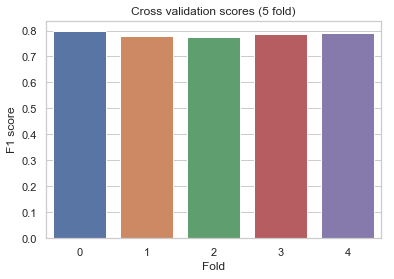

In [62]:
# Perform 5-fold cross validation
scores = cross_val_score(ridge, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Scores :", np.round(scores,2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

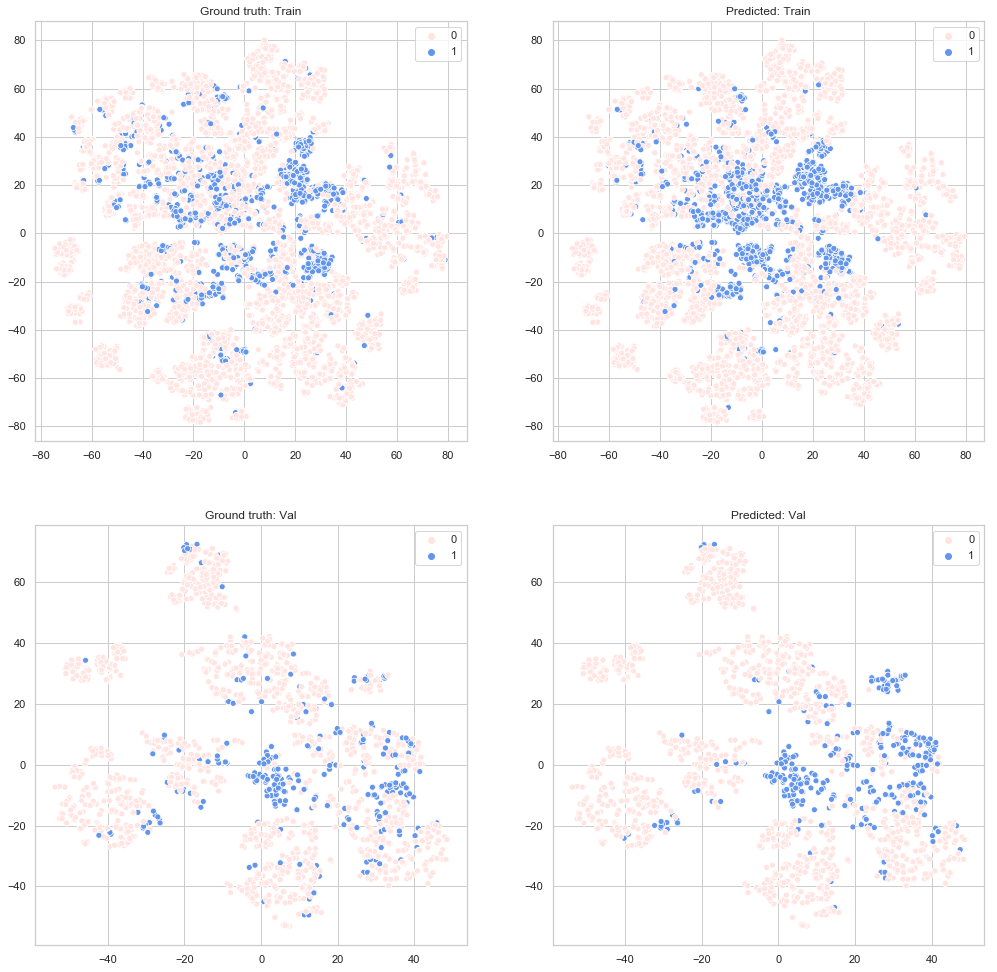

In [31]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

In [32]:
save_to_disk(ridge, "./ridge.pkl")

--------------

# Summary of Logistic Regression:
- Logistic Regression gives a good balance of recall and precision when applied with optimal class weights, and using the significant features
- Regularization does not give significant improvement than standard classification

--------------

# SVM<a id='svm'></a>

SVM using default parameters

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1545
           1       0.68      0.52      0.59       286

    accuracy                           0.89      1831
   macro avg       0.80      0.74      0.76      1831
weighted avg       0.88      0.89      0.88      1831

F1 score: 0.59
Train confusion matrix:


Pred_0  Pred_1
True_0    6959     248
True_1     614     722

Validation confusion matrix:


Pred_0  Pred_1
True_0    1475      70
True_1     138     148

No handles with labels found to put in legend.


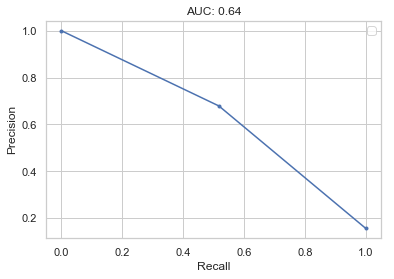

In [59]:
svc = SVC(probability=True)
svc = svc.fit(X=train_data_sm[significant_features], y=train_data[ycol].values.ravel())

train_ylabels = svc.predict(train_data_sm[significant_features])
val_ylabels = svc.predict(val_data_sm[significant_features])

get_classification_reports(svc, val_data_sm[significant_features], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(svc, val_data_sm[significant_features], val_data_sm[ycol])

Cross validation scores :  [0.79 0.76 0.76 0.77 0.79]


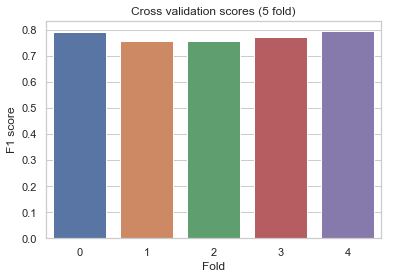

In [60]:
# Perform 5-fold cross validation
scores = cross_val_score(svc, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

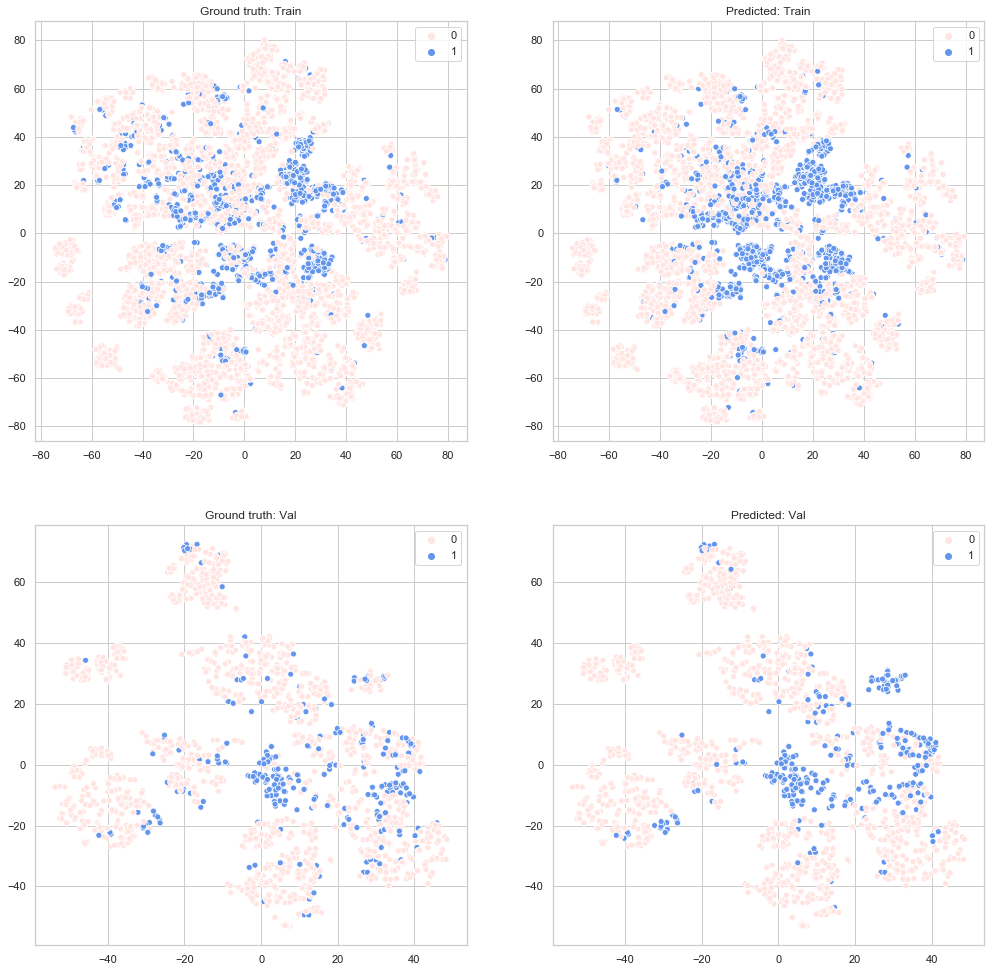

In [35]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

# SVM - significant features and class weights<a id='svm'></a>

In [ ]:
weights = np.linspace(0.15, 0.3, 10)

gsc = GridSearchCV(
    n_jobs=1,
    estimator=SVC(random_state=0),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights],
        'kernel': ['rbf', 'poly', 'linear'],
#         'C': [0.01, 0.1, 1, 10, 100],
#         'degree': [2, 3, 4]
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(train_data_sm[significant_features], train_data_sm[ycol].values.ravel())

print("Best parameters : %s" % grid_result.best_params_)
# Best parameters : {'class_weight': {0: 0.26666666666666666, 1: 0.7333333333333334}, 'kernel': 'rbf'}

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      1545
           1       0.60      0.69      0.64       286

    accuracy                           0.88      1831
   macro avg       0.77      0.80      0.78      1831
weighted avg       0.89      0.88      0.88      1831

F1 score: 0.64
Train confusion matrix:


Pred_0  Pred_1
True_0    6633     574
True_1     362     974

Validation confusion matrix:


Pred_0  Pred_1
True_0    1413     132
True_1      89     197

No handles with labels found to put in legend.


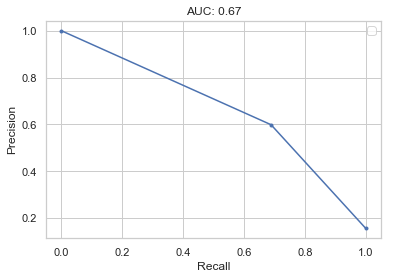

In [41]:
# svc = SVC(probability=True, **grid_result.best_params_)
svc = SVC(probability=True, class_weight={0: 0.26666666666666666, 1: 0.7333333333333334}, kernel='rbf')
svc = svc.fit(X=train_data_sm[significant_features], y=train_data[ycol].values.ravel())

train_ylabels = svc.predict(train_data_sm[significant_features])
val_ylabels = svc.predict(val_data_sm[significant_features])

get_classification_reports(svc, val_data_sm[significant_features], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(svc, val_data_sm[significant_features], val_data_sm[ycol])

Cross validation scores :  [0.81 0.78 0.8  0.8  0.81]


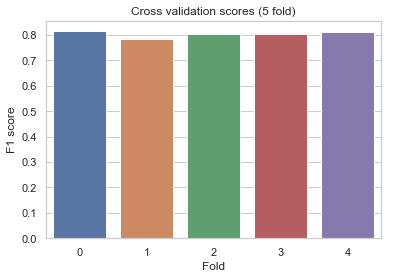

In [49]:
# Perform 5-fold cross validation
scores = cross_val_score(svc, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

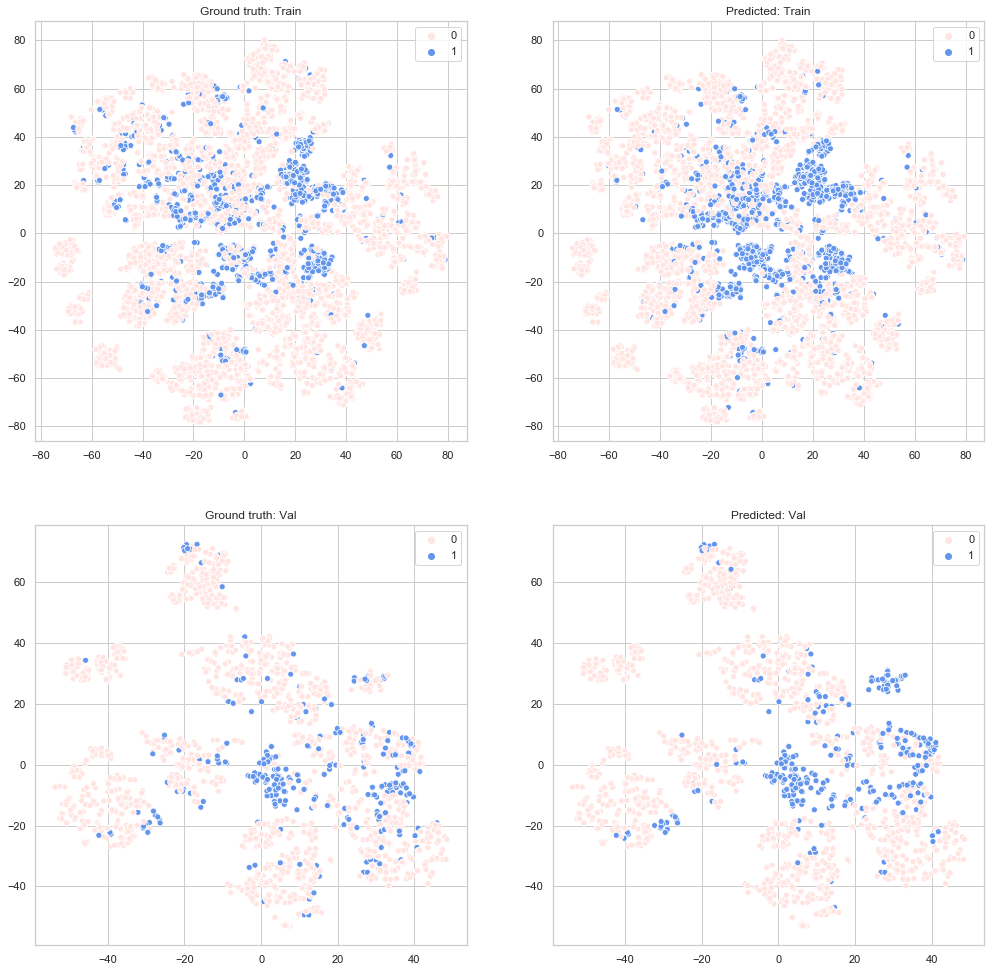

In [35]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

In [36]:
save_to_disk(svc, "./svc.pkl")

# Summary of SVM:
- Used only significant features and class weights
- SVM increases the Recall score without drastically affecting the Precision. We miss out on lesser True positives this way.
- PR AUC increased from 0.67 to 0.7 

------------

# Gradient Boosting Classifiers<a id='gbc'></a>

These generally perform well under imbalanced classes. 

We can try working on the whole feature set first and extracting the significant features.

In [44]:
from xgboost import XGBClassifier, plot_importance

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1545
           1       0.71      0.56      0.63       286

    accuracy                           0.90      1831
   macro avg       0.82      0.76      0.78      1831
weighted avg       0.89      0.90      0.89      1831

F1 score: 0.63
Train confusion matrix:


Pred_0  Pred_1
True_0    7166      41
True_1     191    1145

Validation confusion matrix:


Pred_0  Pred_1
True_0    1481      64
True_1     126     160

No handles with labels found to put in legend.


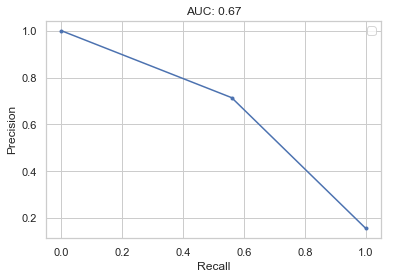

In [45]:
xgb_clf = XGBClassifier()
xgb_clf = xgb_clf.fit(train_data_sm[xcol], train_data_sm[ycol])

train_ylabels = xgb_clf.predict(train_data_sm[xcol])
val_ylabels = xgb_clf.predict(val_data_sm[xcol])

get_classification_reports(xgb_clf, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(xgb_clf, val_data_sm[xcol], val_data_sm[ycol])

Cross validation scores :  [0.78 0.76 0.76 0.78 0.8 ]


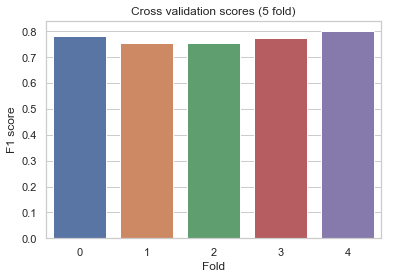

In [48]:
# Perform 5-fold cross validation
scores = cross_val_score(xgb_clf, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

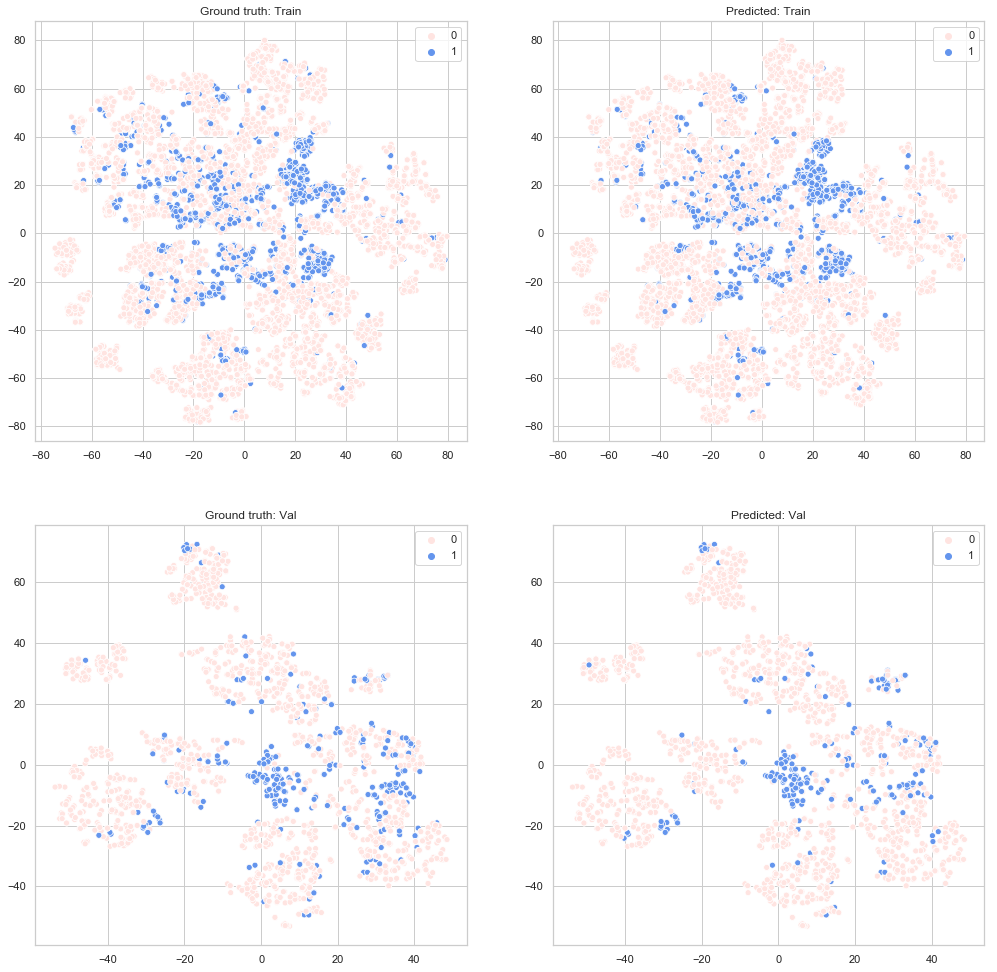

In [39]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

Not bad for a start actually.

Let's have a look at feature importances

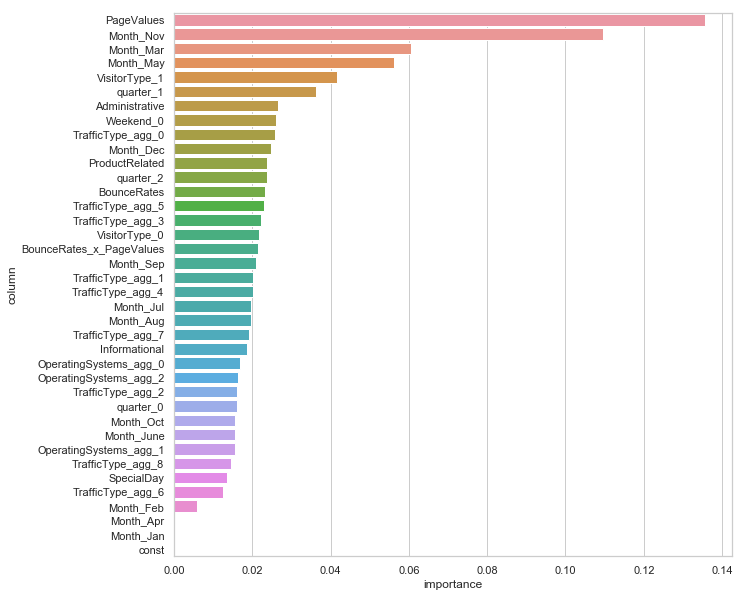

In [40]:
feature_imp_df = pd.DataFrame(list(zip(xcol, xgb_clf.feature_importances_)))
feature_imp_df.columns = ["column", "importance"]
feature_imp_df.sort_values(by="importance", axis=0, inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(y="column", x="importance", data=feature_imp_df, ax=ax)

In [41]:
# Fit model using each importance as a threshold
thresholds = feature_imp_df["importance"].values

num_cols, f1_cols, f1_scores = [], [], []

for thresh in thresholds:
    print("Threshold :", thresh)
    # select features using threshold
    q = "importance>="+str(thresh)
    selection = feature_imp_df.query(q)["column"].values
    print("Selected columns :", selection)
    select_X_train = train_data_sm[selection]

    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, train_data_sm[ycol])
    
    f1s = get_classification_reports(selection_model, 
                                     val_data_sm[selection], val_data_sm[ycol], 
                                     debug=False) 
    
    f1_cols.append(selection)
    num_cols.append(len(selection))
    f1_scores.append(f1s)
    
    print("-"*80)
    
f1_df = pd.DataFrame({"f1_cols":f1_cols, "num_cols":num_cols, "f1_scores":f1_scores})

Threshold : 0.13573090732097626
Selected columns : ['PageValues']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.10961482673883438
Selected columns : ['PageValues' 'Month_Nov']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.06060369685292244
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.05620666220784187
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.04172028228640556
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.03619558736681938
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.026699969545006752
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.02602285146713257
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.025929035618901253
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.024909833446145058
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.023744789883494377
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.023737743496894836
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.023366494104266167
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

--------------------------------------------------------------------------------
Threshold : 0.022905876860022545
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5']
--------------------------------------------------------------------------------
Threshold : 0.022180400788784027
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.02168196067214012
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.021452181041240692
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.020865770056843758
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.020137423649430275
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.02008134499192238
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01974308118224144
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01962796412408352
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.019142072647809982
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.018710540607571602
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.016869455575942993
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01642080768942833
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.016189659014344215
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01598324067890644
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.015667801722884178
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01565106399357319
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01548073161393404
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.014683946967124939
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.0135430246591568
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.01250454131513834
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay'
 'TrafficType_agg_6']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.0059943655505776405
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay'
 'TrafficType_agg_6' 'Month_Feb']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.0
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay'
 'TrafficType_agg_6' 'Month_Feb' 'Month_Apr' 'Month_Jan' 'const']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.0
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay'
 'TrafficType_agg_6' 'Month_Feb' 'Month_Apr' 'Month_Jan' 'const']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------
Threshold : 0.0
Selected columns : ['PageValues' 'Month_Nov' 'Month_Mar' 'Month_May' 'VisitorType_1'
 'quarter_1' 'Administrative' 'Weekend_0' 'TrafficType_agg_0' 'Month_Dec'
 'ProductRelated' 'quarter_2' 'BounceRates' 'TrafficType_agg_5'
 'TrafficType_agg_3' 'VisitorType_0' 'BounceRates_x_PageValues'
 'Month_Sep' 'TrafficType_agg_1' 'TrafficType_agg_4' 'Month_Jul'
 'Month_Aug' 'TrafficType_agg_7' 'Informational' 'OperatingSystems_agg_0'
 'OperatingSystems_agg_2' 'TrafficType_agg_2' 'quarter_0' 'Month_Oct'
 'Month_June' 'OperatingSystems_agg_1' 'TrafficType_agg_8' 'SpecialDay'
 'TrafficType_agg_6' 'Month_Feb' 'Month_Apr' 'Month_Jan' 'const']


d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\softwares\python36\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--------------------------------------------------------------------------------


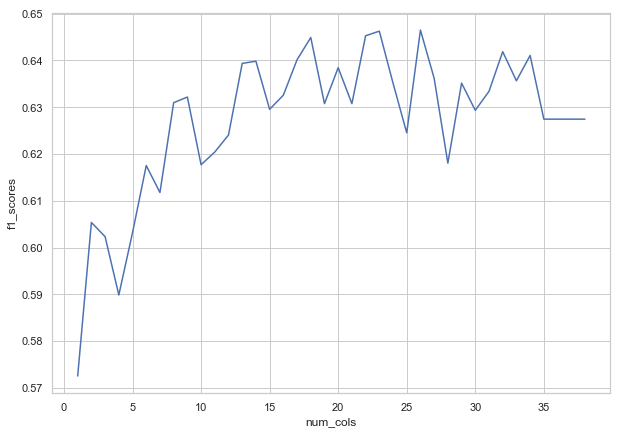

In [42]:
f, ax = plt.subplots(1,1,figsize=(10,7))
g = sns.lineplot(x="num_cols", y="f1_scores", data=f1_df, ax=ax)

Quick parameter tuning to choose the best parameters

In [43]:
weights = np.linspace(0.15, 0.3, 10)

gsc = GridSearchCV(
    estimator=XGBClassifier(n_estimators=100, n_jobs=-1),
    param_grid={
        'alpha': [0,1e-2,1e-3,1e-4]
    },
    scoring='f1',
    cv=5,
)
grid_result = gsc.fit(train_data_sm[xcol], train_data_sm[ycol].values.ravel())

print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'alpha': 0}


# XGBoost with class weights<a id='gbc2'></a>

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1545
           1       0.66      0.66      0.66       286

    accuracy                           0.89      1831
   macro avg       0.80      0.80      0.80      1831
weighted avg       0.89      0.89      0.89      1831

F1 score: 0.66
Train confusion matrix:


Pred_0  Pred_1
True_0    6996     211
True_1     136    1200

Validation confusion matrix:


Pred_0  Pred_1
True_0    1449      96
True_1      97     189

No handles with labels found to put in legend.


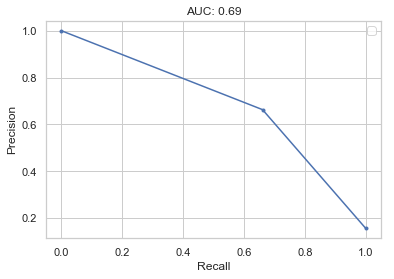

In [50]:
w0 = 0.3
w_array = [w0 if i==0 else 1-w0 for i in train_data_sm[ycol].values]

# xgb_clf = XGBClassifier(n_estimators=100, n_jobs=-1, **grid_result.best_params_)
xgb_clf = XGBClassifier(n_estimators=100, n_jobs=-1, alpha=0)
xgb_clf = xgb_clf.fit(train_data_sm[xcol], train_data_sm[ycol], sample_weight=w_array)

train_ylabels = xgb_clf.predict(train_data_sm[xcol])
val_ylabels = xgb_clf.predict(val_data_sm[xcol])

get_classification_reports(xgb_clf, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(xgb_clf, val_data_sm[xcol], val_data_sm[ycol])

Cross validation scores :  [0.78 0.76 0.76 0.78 0.8 ]


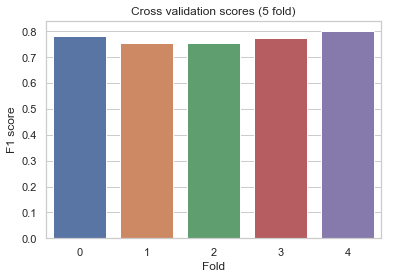

In [51]:
# Perform 5-fold cross validation
scores = cross_val_score(xgb_clf, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

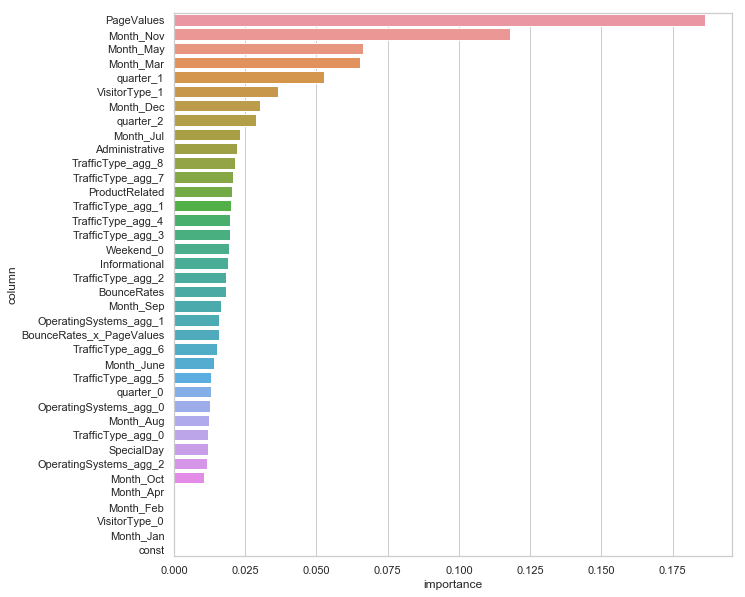

In [14]:
feature_imp_df = pd.DataFrame(list(zip(xcol, xgb_clf.feature_importances_)))
feature_imp_df.columns = ["column", "importance"]
feature_imp_df.sort_values(by="importance", axis=0, inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(y="column", x="importance", data=feature_imp_df, ax=ax)

[Text(0.5, 1.0, 'Predicted: Val')]

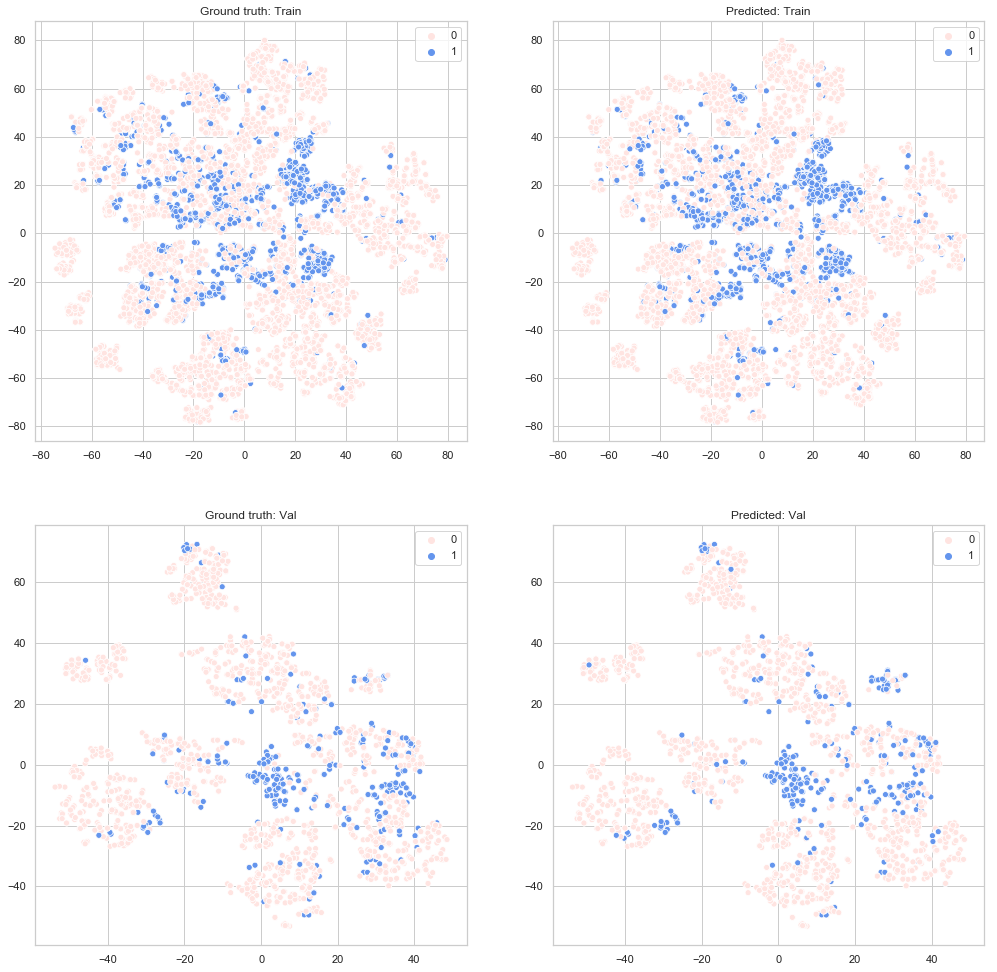

In [45]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

----------

### XGBoost with class weights and features for highest F1

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1545
           1       0.66      0.66      0.66       286

    accuracy                           0.89      1831
   macro avg       0.80      0.80      0.80      1831
weighted avg       0.89      0.89      0.89      1831

F1 score: 0.66
Train confusion matrix:


Pred_0  Pred_1
True_0    7004     203
True_1     177    1159

Validation confusion matrix:


Pred_0  Pred_1
True_0    1446      99
True_1      96     190

No handles with labels found to put in legend.


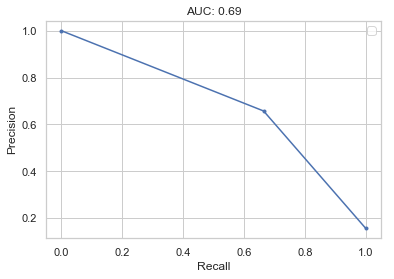

In [52]:
w0 = 0.33
w_array = [w0 if i==0 else 1-w0 for i in train_data_sm[ycol].values]
xcol_subset = ['PageValues', 'Month_Nov', 'Month_Mar', 'Month_May', 'VisitorType_1', 'quarter_1', 'Administrative', 'Weekend_0', 'TrafficType_agg_0', 'Month_Dec', 'ProductRelated', 'quarter_2',
               'BounceRates', 'TrafficType_agg_5', 'TrafficType_agg_3', 'VisitorType_0', 'BounceRates_x_PageValues', 'Month_Sep', 'TrafficType_agg_1', 'TrafficType_agg_4', 'Month_Jul', 'Month_Aug']
s    
# xgb_clf = XGBClassifier(n_estimators=100, n_jobs=-1, **grid_result.best_params_)
xgb_clf = XGBClassifier(n_estimators=100, n_jobs=-1, alpha=0)
xgb_clf = xgb_clf.fit(train_data_sm[xcol_subset], train_data_sm[ycol], sample_weight=w_array)

train_ylabels = xgb_clf.predict(train_data_sm[xcol_subset])
val_ylabels = xgb_clf.predict(val_data_sm[xcol_subset])

get_classification_reports(xgb_clf, val_data_sm[xcol_subset], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(xgb_clf, val_data_sm[xcol_subset], val_data_sm[ycol])

Cross validation scores :  [0.78 0.76 0.76 0.78 0.8 ]


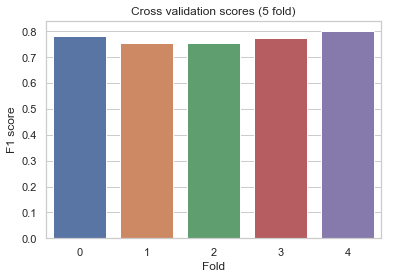

In [53]:
# Perform 5-fold cross validation
scores = cross_val_score(xgb_clf, train_data_sm[significant_features], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

[Text(0.5, 1.0, 'Predicted: Val')]

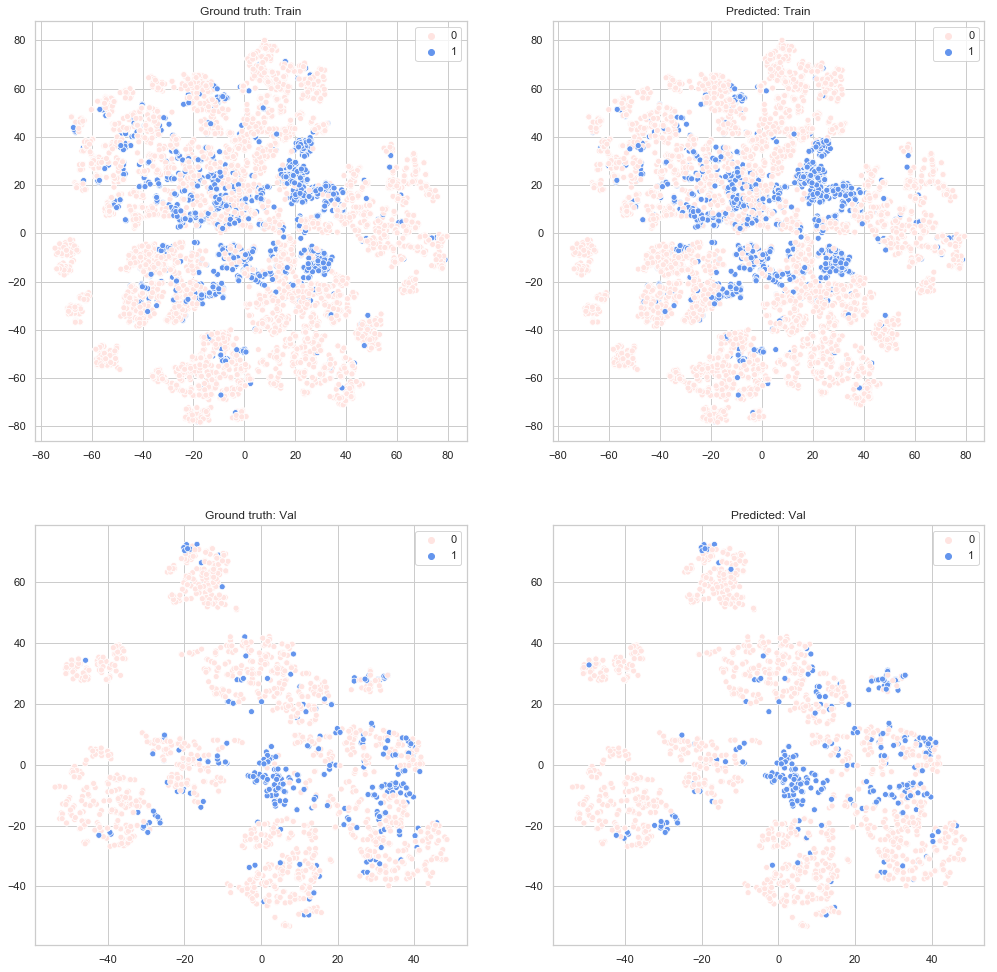

In [47]:
f, ax = plt.subplots(2,2,figsize=(17,17))
g = sns.scatterplot(xs_train,ys_train, hue=train_data[ycol].values.ravel(), ax=ax[0][0], palette=rev_palette)
g.set(title="Ground truth: Train")
g = sns.scatterplot(xs_train,ys_train, hue=train_ylabels, ax=ax[0][1], palette=rev_palette)
g.set(title="Predicted: Train")
g = sns.scatterplot(xs_val,ys_val, hue=val_data[ycol].values.ravel(), ax=ax[1][0], palette=rev_palette)
g.set(title="Ground truth: Val")
g = sns.scatterplot(xs_val,ys_val, hue=val_ylabels, ax=ax[1][1], palette=rev_palette)
g.set(title="Predicted: Val")

In [48]:
save_to_disk(xgb_clf, "./xgb_clf.pkl")

-----------

# Random Forest<a id='rf'></a>

In [54]:
from sklearn.ensemble import RandomForestClassifier

Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1545
           1       0.75      0.57      0.65       286

    accuracy                           0.90      1831
   macro avg       0.84      0.77      0.80      1831
weighted avg       0.90      0.90      0.90      1831

F1 score: 0.65
Train confusion matrix:


Pred_0  Pred_1
True_0    7205       2
True_1       8    1328

Validation confusion matrix:


Pred_0  Pred_1
True_0    1491      54
True_1     122     164

No handles with labels found to put in legend.


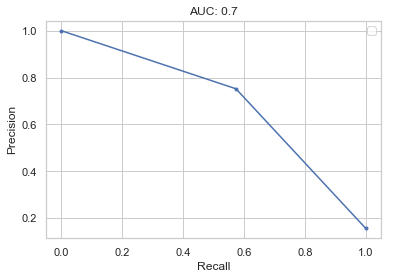

In [55]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(train_data_sm[xcol], train_data_sm[ycol])

train_ylabels = rf.predict(train_data_sm[xcol])
val_ylabels = rf.predict(val_data_sm[xcol])

get_classification_reports(rf, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(rf, val_data_sm[xcol], val_data_sm[ycol])

Cross validation scores :  [0.81 0.77 0.78 0.79 0.81]


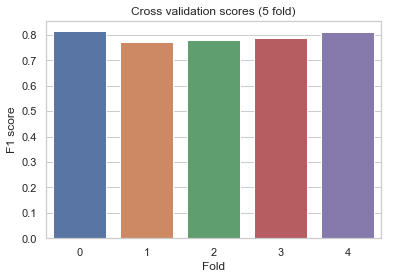

In [56]:
# Perform 5-fold cross validation
scores = cross_val_score(rf, train_data_sm[xcol], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

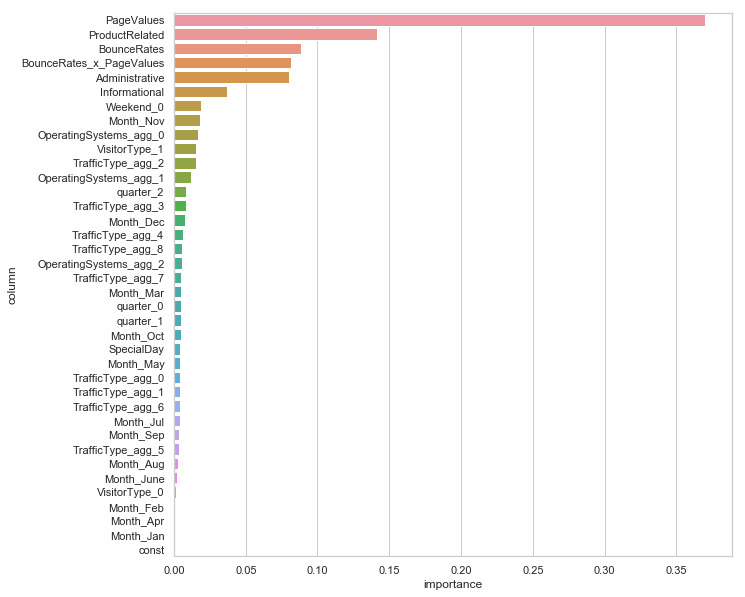

In [23]:
feature_imp_df = pd.DataFrame(list(zip(xcol, rf.feature_importances_)))
feature_imp_df.columns = ["column", "importance"]
feature_imp_df.sort_values(by="importance", axis=0, inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(y="column", x="importance", data=feature_imp_df, ax=ax)

In [21]:
weights = np.linspace(0.15, 0.3, 10)

gsc = GridSearchCV(
    n_jobs=1,
    estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights],
        'min_samples_split': [2,3,5],
        'max_features': ['sqrt', 'log2', None, int(len(xcol)/2)],
    },
    scoring='f1',
    cv=5
)
grid_result = gsc.fit(train_data_sm[xcol], train_data_sm[ycol].values.ravel())

print("Best parameters : %s" % grid_result.best_params_)

#Best parameters : {'class_weight': {0: 0.21666666666666667, 1: 0.7833333333333333},
#                 'max_features': 'sqrt', 'min_samples_split': 5}

Best parameters : {'class_weight': {0: 0.21666666666666667, 1: 0.7833333333333333}, 'max_features': 'sqrt', 'min_samples_split': 5}


Classification Reports ---


Validation data:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1545
           1       0.71      0.63      0.66       286

    accuracy                           0.90      1831
   macro avg       0.82      0.79      0.80      1831
weighted avg       0.90      0.90      0.90      1831

F1 score: 0.66
Train confusion matrix:


Pred_0  Pred_1
True_0    7112      95
True_1      43    1293

Validation confusion matrix:


Pred_0  Pred_1
True_0    1471      74
True_1     107     179

No handles with labels found to put in legend.


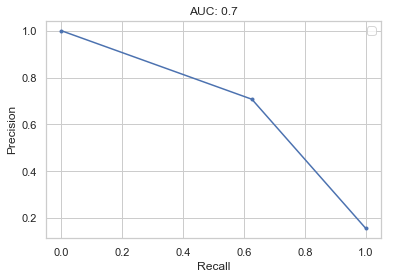

In [57]:

# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, **grid_result.best_params_)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight={0: 0.21666666666666667, 1: 0.7833333333333333},
                           max_features='sqrt', min_samples_split=5)
rf.fit(train_data_sm[xcol], train_data_sm[ycol])

train_ylabels = rf.predict(train_data_sm[xcol])
val_ylabels = rf.predict(val_data_sm[xcol])

get_classification_reports(rf, val_data_sm[xcol], val_data_sm[ycol])

print("Train confusion matrix:")   
display(get_confusion_mat(train_data[ycol].values.ravel(), train_ylabels))

print("Validation confusion matrix:") 
display(get_confusion_mat(val_data[ycol].values.ravel(), val_ylabels))

pr_curve(rf, val_data_sm[xcol], val_data_sm[ycol])

Cross validation scores :  [0.82 0.77 0.79 0.81 0.83]


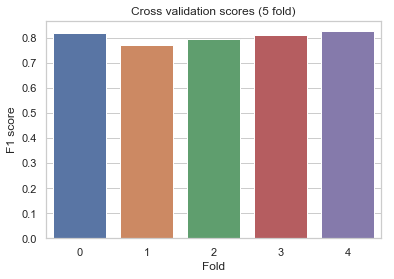

In [58]:
# Perform 5-fold cross validation
scores = cross_val_score(rf, train_data_sm[xcol], train_data_sm[ycol], cv=5, scoring='f1_macro')
print("Cross validation scores : ", np.round(scores, 2))
g= sns.barplot(x=list(range(5)), y=scores)
y = g.set(title="Cross validation scores (5 fold)", xlabel="Fold", ylabel="F1 score")

In [19]:
save_to_disk(rf, "./rf.pkl")

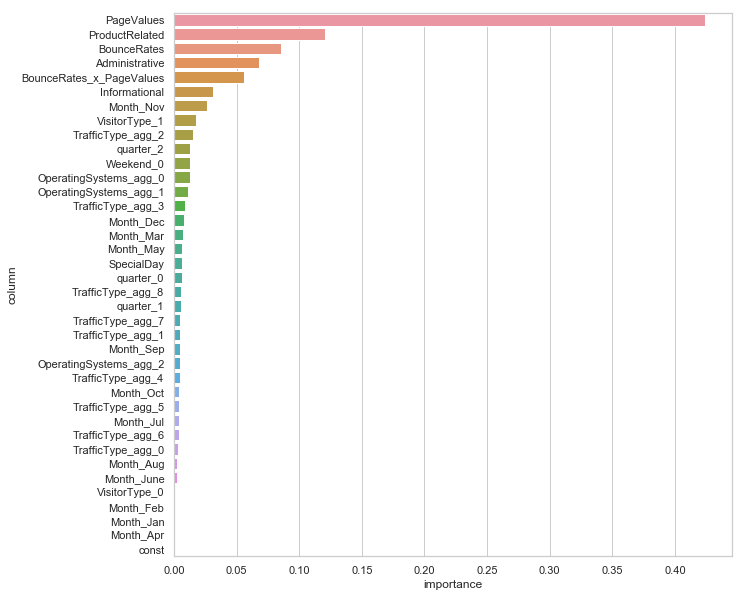

In [20]:
feature_imp_df = pd.DataFrame(list(zip(xcol, rf.feature_importances_)))
feature_imp_df.columns = ["column", "importance"]
feature_imp_df.sort_values(by="importance", axis=0, inplace=True, ascending=False)
f, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(y="column", x="importance", data=feature_imp_df, ax=ax)

-------------

# Summary<a id='summary'></a>

Ultimately, all the models have very comparable scores with corresponding trade offs. 

Let's plot F1 scores, precision and recall for all the best models for each algorithm.

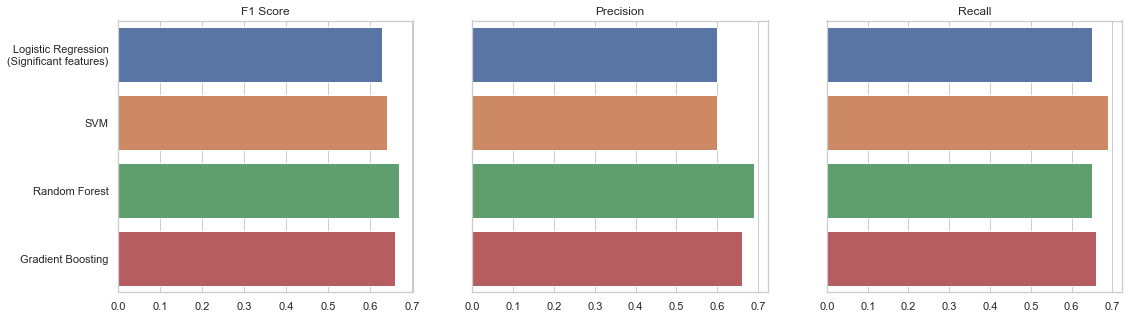

In [29]:
model_dict = {
    "Model":["Logistic Regression\n(Significant features)", "SVM", "Random Forest", "Gradient Boosting"],
    "F1 Score":[0.63, 0.64, 0.67, 0.66],
    "Precision":[0.60, 0.60, 0.69, 0.66],
    "Recall":[0.65, 0.69, 0.65, 0.66],
             }
model_df = pd.DataFrame(model_dict)
f, ax = plt.subplots(1,3, figsize=(18, 5), sharey=True)
clrs = ['lightgreen' if i == model_df["F1 Score"].max() else 'lightblue' for i in model_df["F1 Score"].values]
g = sns.barplot(y="Model", x="F1 Score", data=model_df, ax=ax[0]) #,palette=clrs)
y=g.set(title="F1 Score", ylabel='', xlabel='')

clrs = ['lightgreen' if i == model_df["Precision"].max() else 'lightblue' for i in model_df["Precision"].values]
g = sns.barplot(y="Model", x="Precision", data=model_df, ax=ax[1]) #, palette=clrs)
y=g.set(title="Precision", ylabel='', xlabel='')

clrs = ['lightgreen' if i == model_df["Recall"].max() else 'lightblue' for i in model_df["Recall"].values]
g = sns.barplot(y="Model", x="Recall", data=model_df, ax=ax[2]) #, palette=clrs)
y=g.set(title="Recall", ylabel='', xlabel='')

In [30]:
model_df

Model  F1 Score  Precision  Recall
0  Logistic Regression\n(Significant features)      0.63       0.60    0.65
1                                          SVM      0.64       0.60    0.69
2                                Random Forest      0.67       0.69    0.65
3                            Gradient Boosting      0.66       0.66    0.66

To proceed, we can stick with Logistic Regression to enable us to interpret the coefficients and the magnitude of effects as well.

------------